### Overview

The aim of this notebook is to provide the user understanding of how to use LSTMs with keras. Using the example of time series like data, we show how LSTMs can be used for predicting next samples in time series. Also, we show the difference between stateful and stateless LSTMs and how to arrange data for using it with LSTMs.

Let's dive into it!

In [1]:
# Import the required libraries
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import copy

Using TensorFlow backend.


In [2]:
train_proportion = 0.8 # Proportion of data going into training set
batch_size = 128
num_epochs = 100

### Dataset used

We consider the input of cosine series. We wish the LSTM to be able to generate the cosine sequence given any small portion of it. We generate the series for 10 cosine cycles below. The frequency used is 1/100.  

Text(0,0.5,'Cos(theta)')

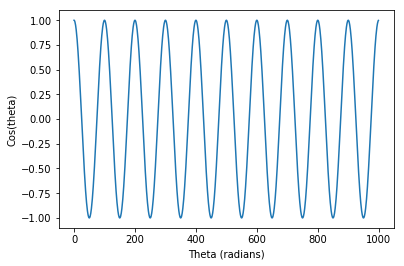

In [3]:
freq = 1.0/100
t = np.arange(1000)
dataset = np.cos(t * 2 * np.pi * freq)
plt.plot(t, dataset)
plt.xlabel('Theta (radians)')
plt.ylabel('Cos(theta)')

Function to convert a time series of data into input, output pairs based on the lookback interval. \[$t_0$, $t_{lookback-1}$\] is the input interval and ouput at $t_{lookback}$ is the output.<br>
The input continuous time series dataset is converted into $len(input dataset) - lookback$ input output pairs.

In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Window of 20 time steps

In [5]:
look_back = 20

dataset = dataset.reshape(-1,1)
# split into train and test sets
train_size = int(len(dataset) * train_proportion)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

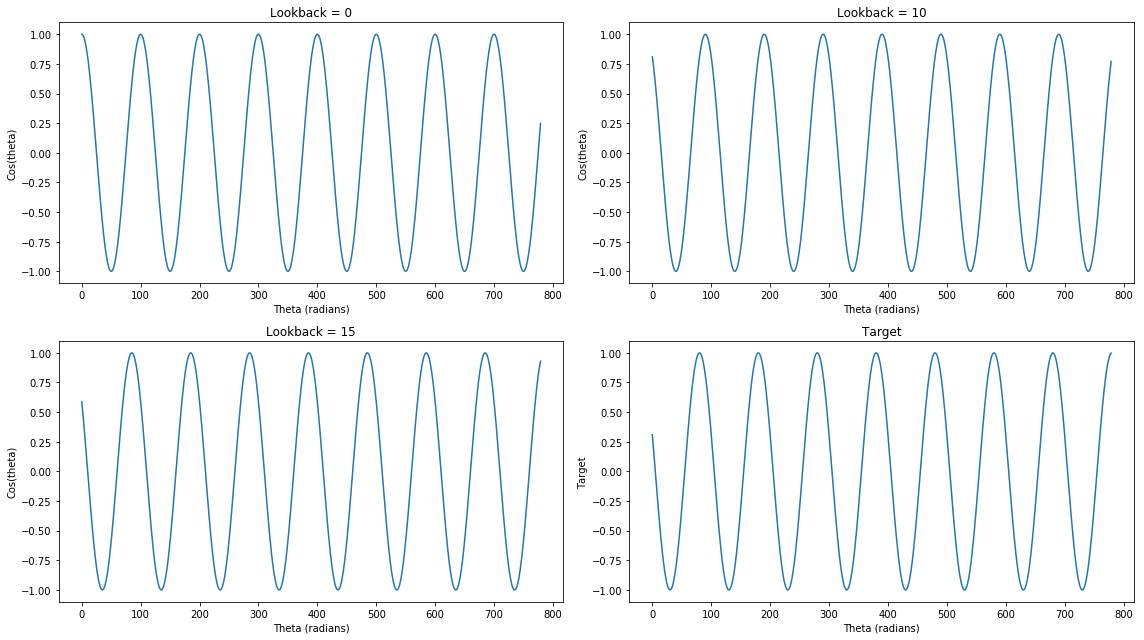

In [6]:
plt.figure(figsize=[16,9])
plt.subplot(2,2,1)
plt.plot(trainX[:,0,0]); plt.xlabel('Theta (radians)'); plt.ylabel('Cos(theta)'); plt.title('Lookback = 0')
plt.subplot(2,2,2)
plt.plot(trainX[:,10,0]); plt.xlabel('Theta (radians)'); plt.ylabel('Cos(theta)'); plt.title('Lookback = 10')
plt.subplot(2,2,3)
plt.plot(trainX[:,15,0]); plt.xlabel('Theta (radians)'); plt.ylabel('Cos(theta)'); plt.title('Lookback = 15')
plt.subplot(2,2,4)
plt.plot(trainY); plt.xlabel('Theta (radians)'); plt.ylabel('Target'); plt.title('Target')
plt.tight_layout()

In [7]:
print('Training data shape: {}'.format(trainX.shape))
print('# Samples: {}'.format(trainX.shape[0]))
print('Lookback Interval: {}'.format(trainX.shape[1]))
print('# features: {}'.format(trainX.shape[2]))

Training data shape: (780, 20, 1)
# Samples: 780
Lookback Interval: 20
# features: 1


In [8]:
print('Target Shape: {}'.format(trainY.shape))

Target Shape: (780,)


In [9]:
%%time
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(32,input_shape=(None, 1), name="LSTM")) # input_dim is required for stateless LSTMs, batch size not compulsory
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=2, validation_split=0.2)

Train on 624 samples, validate on 156 samples
Epoch 1/100
 - 1s - loss: 0.4338 - val_loss: 0.3704
Epoch 2/100
 - 0s - loss: 0.3137 - val_loss: 0.2583
Epoch 3/100
 - 0s - loss: 0.2137 - val_loss: 0.1704
Epoch 4/100
 - 0s - loss: 0.1450 - val_loss: 0.1109
Epoch 5/100
 - 0s - loss: 0.1110 - val_loss: 0.0852
Epoch 6/100
 - 0s - loss: 0.0947 - val_loss: 0.0796
Epoch 7/100
 - 0s - loss: 0.0893 - val_loss: 0.0727
Epoch 8/100
 - 0s - loss: 0.0834 - val_loss: 0.0637
Epoch 9/100
 - 0s - loss: 0.0709 - val_loss: 0.0573
Epoch 10/100
 - 0s - loss: 0.0643 - val_loss: 0.0528
Epoch 11/100
 - 0s - loss: 0.0609 - val_loss: 0.0473
Epoch 12/100
 - 0s - loss: 0.0551 - val_loss: 0.0405
Epoch 13/100
 - 0s - loss: 0.0499 - val_loss: 0.0342
Epoch 14/100
 - 0s - loss: 0.0441 - val_loss: 0.0281
Epoch 15/100
 - 0s - loss: 0.0391 - val_loss: 0.0226
Epoch 16/100
 - 0s - loss: 0.0359 - val_loss: 0.0171
Epoch 17/100
 - 0s - loss: 0.0266 - val_loss: 0.0124
Epoch 18/100
 - 0s - loss: 0.0253 - val_loss: 0.0085
Epoch 19/

In [10]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train {}: {}'.format(model.metrics_names[0],trainScore))
testScore = model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
print('Test {}: {}'.format(model.metrics_names[0], testScore))

Train loss: 0.00028461355339879025
Test loss: 0.00029316057787380284


In [11]:
look_ahead = 160
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([trainPredict[-1]]))
    predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))

In [12]:
mse = np.mean((dataset[train_size:(train_size+look_ahead)] - predictions)**2)
print('Mean squared error: {}'.format(mse))

Mean squared error: 0.14197525195702076


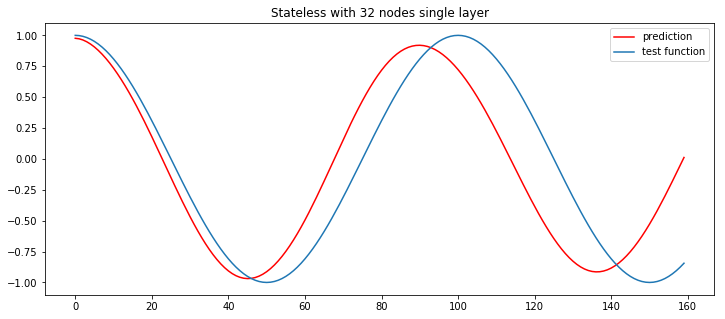

In [13]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.title('Stateless with 32 nodes single layer')
plt.legend()
plt.show()

## Stateful LSTMs (Training and Prediction)

Stateful parameter helps us carry forward the cell states across batches. The cell state of an element in the batch is carried forward to the corresponding element in the next batch.

To make use of this property, we rearrange our dataset in such a way that consequtive elements are lined up as the corresponding elements in differnt batches.

In [14]:
def stateful_setup(x, y, batch_size):
    lot_size = int(np.floor(x.shape[0]/ batch_size))
    current_index = 0
    l =[[] for i in range(lot_size)]
    m =[[] for i in range(lot_size)]
    for i in range(batch_size):
        for j in range(lot_size):
            l[j].append(x[current_index])
            m[j].append(y[current_index])
            current_index += 1
    return np.vstack(l),np.hstack(m) 

In [15]:
# The rearranged training data which can make use of the stateful property
trainX_stateful,trainY_stateful  = stateful_setup(trainX, trainY, 32)
print(trainX_stateful.shape, trainY_stateful.shape)

(768, 20, 1) (768,)


In [16]:
%%time
# create and fit the LSTM network
batch_size = 32
stateful_model = Sequential()
stateful_model.add(LSTM(32,batch_input_shape=(batch_size, look_back, 1), stateful=True))
stateful_model.add(Dropout(0.3))
stateful_model.add(Dense(1))
stateful_model.compile(loss='mean_squared_error', optimizer='adam')
stateful_model.fit(trainX_stateful, trainY_stateful, nb_epoch=100, batch_size=batch_size, verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/100
 - 1s - loss: 0.3748
Epoch 2/100
 - 0s - loss: 0.1148
Epoch 3/100
 - 0s - loss: 0.0706
Epoch 4/100
 - 0s - loss: 0.0439
Epoch 5/100
 - 0s - loss: 0.0229
Epoch 6/100
 - 0s - loss: 0.0135
Epoch 7/100
 - 0s - loss: 0.0139
Epoch 8/100
 - 0s - loss: 0.0127
Epoch 9/100
 - 0s - loss: 0.0133
Epoch 10/100
 - 0s - loss: 0.0125
Epoch 11/100
 - 0s - loss: 0.0114
Epoch 12/100
 - 0s - loss: 0.0110
Epoch 13/100
 - 0s - loss: 0.0109
Epoch 14/100
 - 0s - loss: 0.0100
Epoch 15/100
 - 0s - loss: 0.0104
Epoch 16/100
 - 0s - loss: 0.0098
Epoch 17/100
 - 0s - loss: 0.0102
Epoch 18/100
 - 0s - loss: 0.0093
Epoch 19/100
 - 0s - loss: 0.0093
Epoch 20/100
 - 0s - loss: 0.0101
Epoch 21/100
 - 0s - loss: 0.0086
Epoch 22/100
 - 0s - loss: 0.0096
Epoch 23/100
 - 0s - loss: 0.0083
Epoch 24/100
 - 0s - loss: 0.0087
Epoch 25/100
 - 0s - loss: 0.0080
Epoch 26/100
 - 0s - loss: 0.0080
Epoch 27/100
 - 0s - loss: 0.0082
Epoch 28/100
 - 0s - loss: 0.0084
Epoch 29/100
 - 0s - loss: 0.0090
Epoch 30/100
 - 0s - lo

In [17]:
stateful_model.save_weights('/tmp/stateful_lstm.h5')

In [18]:
batch_size = 1
stateful_model = Sequential()
stateful_model.add(LSTM(32,batch_input_shape=(batch_size, look_back, 1), stateful=True))
stateful_model.add(Dropout(0.3))
stateful_model.add(Dense(1))
stateful_model.compile(loss='mean_squared_error', optimizer='adam')
stateful_model.load_weights('/tmp/stateful_lstm.h5')

In [19]:
look_ahead = 160
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
stateful_predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = stateful_model.predict(np.array([trainPredict[-1]]), batch_size=1)
    stateful_predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))

In [20]:
trainPredict[1].shape

(20, 1)

In [21]:
mse = np.mean((dataset[train_size:(train_size+look_ahead)] - stateful_predictions)**2)
print('Mean squared error: {}'.format(mse))

Mean squared error: 0.22543967599134973


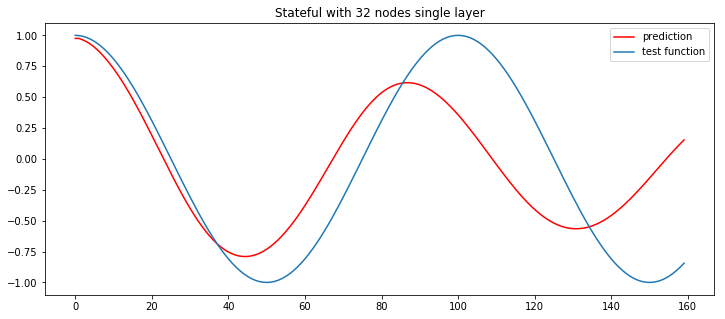

In [22]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),stateful_predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.title('Stateful with 32 nodes single layer')
plt.legend()
plt.show()

## Stateful LSTMs

In [23]:
import json
from keras.models import model_from_json

def convert_to_inference_model(original_model):
    original_model_json = original_model.to_json()
    inference_model_dict = json.loads(original_model_json)

    layers = inference_model_dict['config']
    for layer in layers:
        if 'stateful' in layer['config']:
            layer['config']['stateful'] = True

        if 'batch_input_shape' in layer['config']:
            layer['config']['batch_input_shape'][0] = 1
            layer['config']['batch_input_shape'][1] = None

    inference_model = model_from_json(json.dumps(inference_model_dict))
    inference_model.set_weights(original_model.get_weights())

    return inference_model

In [24]:
model_stateful2 = convert_to_inference_model(model)
model_stateful2.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
# model_stateful2.get_layer(name='LSTM').__dict__

In [26]:
print(model_stateful2.get_layer(name="LSTM").stateful)
print(model.get_layer(name="LSTM").stateful)

True
False


In [27]:
trainScore = model_stateful2.evaluate(trainX, trainY, batch_size=1, verbose=0)
print('Train Score: ', trainScore)
testScore = model_stateful2.evaluate(testX[:252], testY[:252], batch_size=1, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.0028816847371695843
Test Score:  0.002737547855357264


In [28]:
look_ahead = 160
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions_stateful = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model_stateful2.predict(np.array([trainPredict[-1]]), batch_size=1)
    predictions_stateful[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))

In [29]:
np.mean((dataset[train_size:(train_size+look_ahead)] - predictions_stateful)**2)

2.2995941326536835

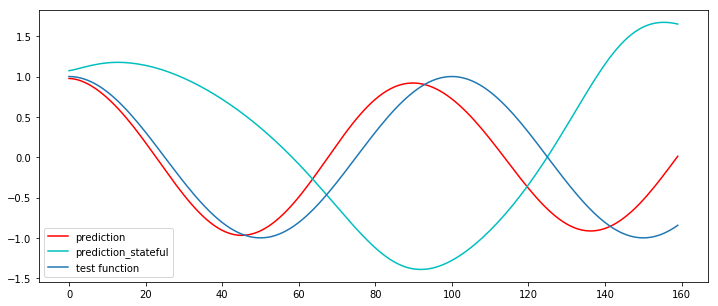

In [30]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),predictions_stateful,'c',label="prediction_stateful")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.legend()
plt.show()